In [3]:
# Prophet model for time series forecast
import os
import darts
import prophet
import pyspark

# Data processing
import pandas as pd
import numpy as np
import csv

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from prophet import Prophet

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

#hmm needed? 
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

%matplotlib inline
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


import matplotlib.pyplot as plt
from sklearn.cluster import BisectingKMeans
from datetime import datetime



In [9]:
#Data preparation
#Define data path
data_path = '/work/Data-Science-Liv/Data/life_expectancy.csv'

data = pd.read_csv(data_path)

#Make datetime
data['Year'] = pd.to_datetime(data['Year'])

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World', 'Americas']

# Subset the DataFrame based on the countries of interest
data_countries = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


#Transform dataset into TimeSeries
#Create ultiple time series by group
dataset_ts = TimeSeries.from_group_dataframe(df=data_countries, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')


#Scale the target values
# from darts.dataprocessing.transformers import Scaler
# scaler = Scaler()

# #Scale the full dataset
# dataset_ts_scaled = scaler.fit_transform(dataset_ts)

#Split in train, val, and test

#We set aside 75% for training - 54 years (1950-2004)
#And set asise 25% for testing - 17 years (2005-2021)

# first_test_date = pd.Timestamp('2005-01-01')
# train_dataset_ts, test_dataset_ts = [], []

# for single_ts in tqdm(dataset_ts_scaled):
#     # split into train and test tests
#     single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
#     train_dataset_ts.append(single_train_ts)
#     test_dataset_ts.append(single_test_ts)


/tmp/ipykernel_3544/4039746813.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


In [3]:
#Inspect columns
print(data_countries.columns)

Index(['Country', 'Year', 'LE'], dtype='object')


<AxesSubplot:xlabel='Year', ylabel='LE'>

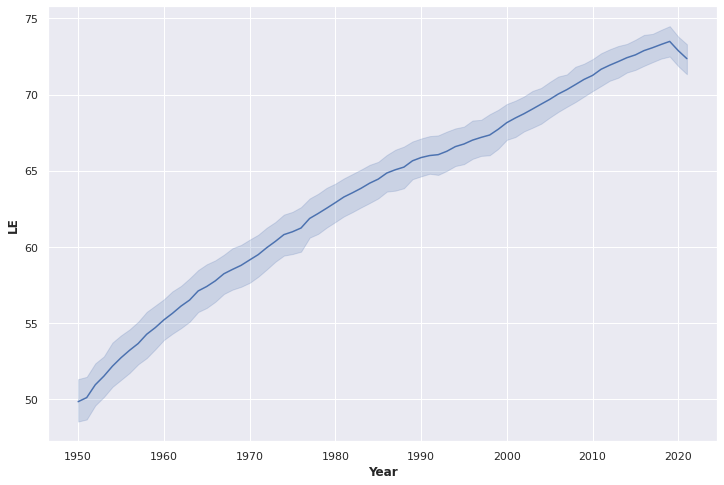

In [11]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data_countries['Year'], y=data_countries['LE'])

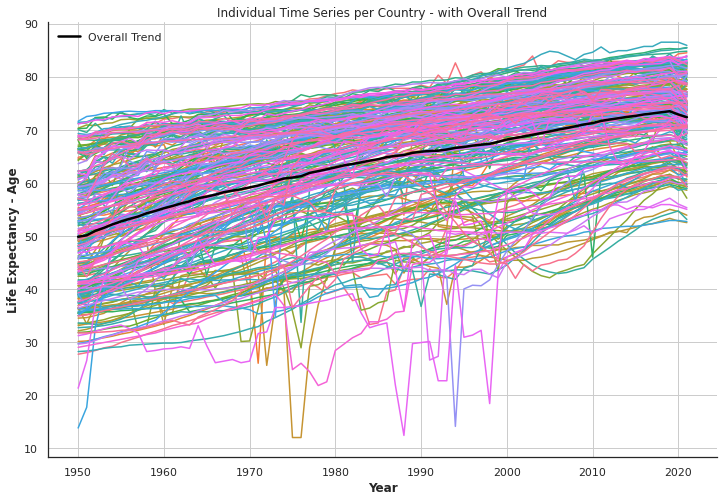

In [15]:
# Set the figure size and background color
sns.set(rc={'figure.figsize': (12, 8)})
sns.set_style("white")  # Set the style to white

# Plotting individual time series per country with overlapping lines and no legend
sns.lineplot(x='Year', y='LE', hue='Country', data=data_countries, legend=False)

# Calculate the overall trend (e.g., average)
overall_trend = data_countries.groupby('Year')['LE'].mean()

# Plot the overall trend line
plt.plot(overall_trend.index, overall_trend, color='black', linestyle='-', lw=2.5, label='Overall Trend')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Life Expectancy - Age')
plt.title('Individual Time Series per Country - with Overall Trend')
plt.grid(True)  
plt.legend()

# Remove the box around the plot
sns.despine()
plt.show()


In [5]:
#Data processing
data = pd.read_csv('/work/Data-Science-Liv/Data/life_expectancy.csv')

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World', 'Americas']

# Subset the DataFrame based on the countries of interest
data_countries_1 = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries_1.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)

#data_countries_1['Year'] = pd.to_datetime(data_countries_1['Year'])


#Pivot data differently  to preserve individual time series
pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

#Transform dataset into TimeSeries
#Create ultiple time series by group
# data_countries_1_ts = TimeSeries.from_group_dataframe(df=data_countries_1, 
#                                              group_cols=['Country'],
#                                              time_col='Year', 
#                                              value_cols='LE')

#Convert data to matrix
#data_matrix = pivoted_data.values





/tmp/ipykernel_3544/3696624117.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries_1.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


In [4]:
# Checking unique countries
unique_countries = data_countries_1['Country'].unique()
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bonaire Sint Eustatius and Saba' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brunei' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Cuba' 'Curacao' 'Cyprus' 'Czechia'
 'Democratic Republic of Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Faeroe Islands'
 'Falkland Islands' 'Fiji' 'Finland' 'France' 'French Guiana'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Gibral

## Creating Clusters

#### Deciding the best number of clusters

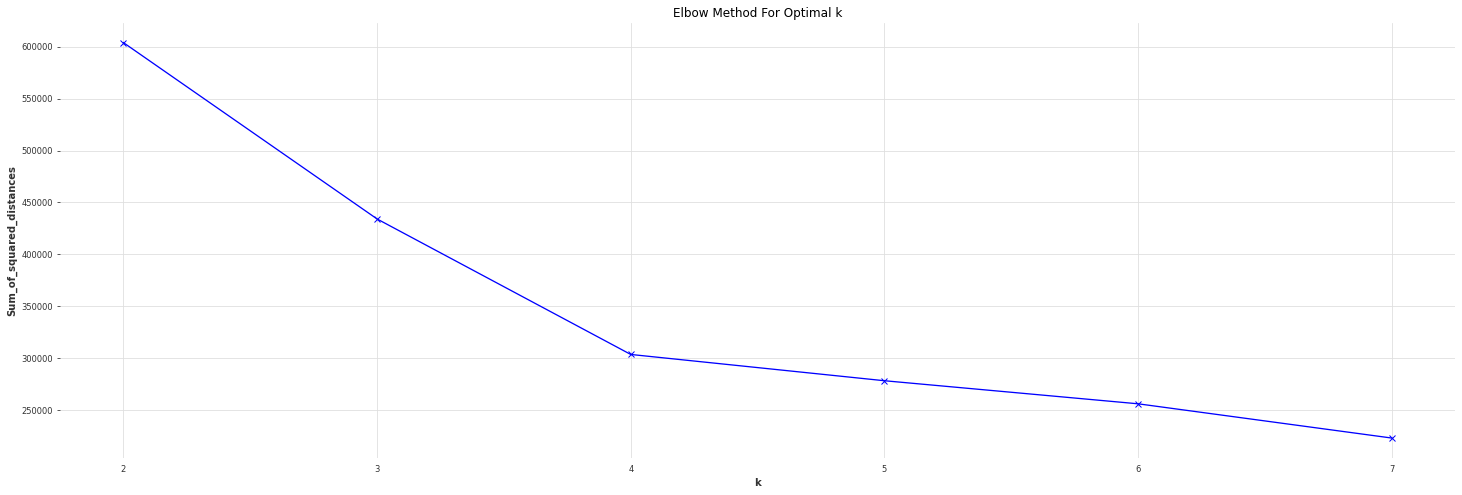

In [5]:
## Deciding how many clusters to use
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = BisectingKMeans(n_clusters=k,
                          n_init=2,
                          verbose=False,
                          bisecting_strategy = "biggest_inertia")
    
    km = km.fit(time_series)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems like the optimal number of clusters is 4. After this, the sum of squared distances is not decreasing much as K increases

### Performing the clustering and saving them i long format

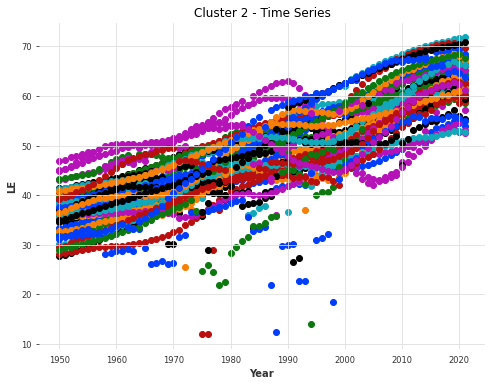

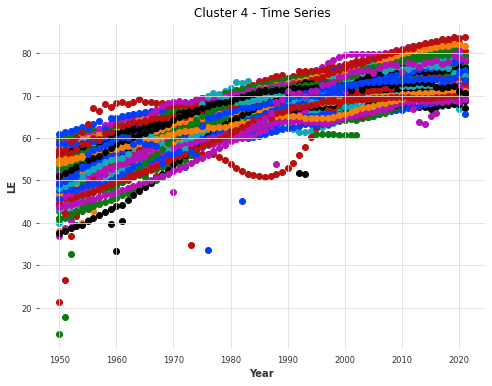

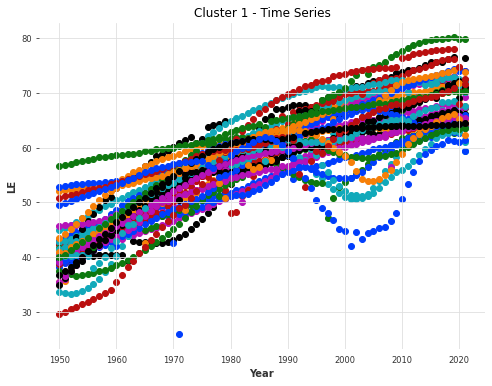

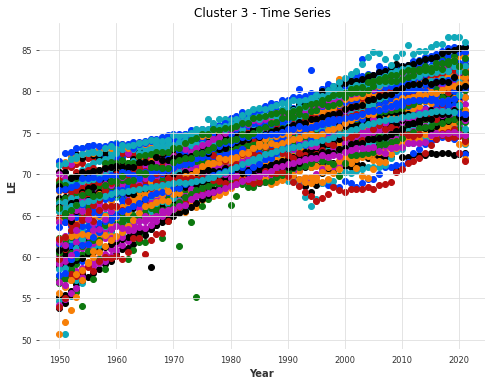

In [7]:
# Long format
np.random.seed(45)

# Pivot data differently to preserve individual time series
pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# Convert the pivot data to a list of time series
time_series = pivoted_data.values.tolist()

# Build and fit the model on the list of time series
bisect_means = BisectingKMeans(n_clusters=4, bisecting_strategy="biggest_inertia").fit(time_series)

# Get the cluster labels and cluster centers
labels = bisect_means.labels_
centers = bisect_means.cluster_centers_

# Create a dictionary to store the clustered data
clustered_data = {}

# Iterate over each country and its corresponding label
for country, label in zip(pivoted_data.index, labels):
    # Check if the cluster label is already in the dictionary
    if label in clustered_data:
        # Append the country's time series and label to the existing cluster
        clustered_data[label].append((country, pivoted_data.loc[country]))
    else:
        # Create a new cluster and store the country's time series and label
        clustered_data[label] = [(country, pivoted_data.loc[country])]

# Create folder for saving the cluster files if it doesn't exist
if not os.path.exists('clustered_data'):
    os.makedirs('clustered_data')

# Save the clustered data to separate CSV files and create scatter plots
for label, data in clustered_data.items():
    # Create a list to store the long format data rows
    long_data = []

    for country, ts in data:
        # Convert date strings to datetime objects and extract the year
        years = [datetime.strptime(date, '%Y-%m-%d').year for date in ts.index]

        # Append the long format data for each year to the list
        long_data.extend(zip([country]*len(years), years, ts.values))

    # Create a DataFrame from the long format data
    long_df = pd.DataFrame(long_data, columns=['Country', 'Year', 'LE'])

    # Create a file for each cluster
    filename = f"clustered_data/long_cluster_{label}_full.csv"

    # Save the long format data to a CSV file
    long_df.to_csv(filename, index=False)

    # Create a scatter plot for each cluster
    plt.figure(figsize=(8, 6))
    for _, ts in data:
        # Convert date strings to datetime objects and extract the year
        x = [datetime.strptime(date, '%Y-%m-%d').year for date in ts.index]
        plt.scatter(x, ts.values)

    # Set x-axis ticks to display every 10 years
    x_ticks = np.arange(x[0], x[-1] + 1, 10)
    plt.xticks(x_ticks)

    plt.title(f"Cluster {label + 1} - Time Series")
    plt.xlabel("Year")
    plt.ylabel("LE")
    plt.show()


#### Ensuring no countries are assigned to more clusters
This might however  not be desireable, since the point of each cluster is just to perform the cluster forecasting method, and not to describe the data

In [11]:
#Only one cluster per country
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.cluster import BisectingKMeans

# # Pivot data differently to preserve individual time series
# pivoted_data = data_countries_1.pivot(index='Country', columns='Year', values='LE')

# # Convert the pivot data to a list of time series
# time_series = pivoted_data.values.tolist()

# # Build and fit the model on the list of time series
# bisect_means = BisectingKMeans(n_clusters=5).fit(time_series)

# # Get the cluster labels and cluster centers
# labels = bisect_means.labels_
# centers = bisect_means.cluster_centers_

# # Create a dictionary to store the clustered data
# clustered_data = {}

# # Iterate over each country and its corresponding label
# for country, label in zip(pivoted_data.index, labels):
#     # Check if the country has already been assigned to a cluster

#     assigned_cluster = None
#     for cluster_label, data in clustered_data.items():
#         for _, ts in data:
#             if country == _:
#                 assigned_cluster = cluster_label
#                 break
    
#     if assigned_cluster is not None:
#         # Country is already assigned to a cluster, skip it
#         continue

#     # Append the country's time series and label to the existing cluster
#     if label in clustered_data:
#         clustered_data[label].append((country, pivoted_data.loc[country]))
#     else:
#         # Create a new cluster and store the country's time series and label
#         clustered_data[label] = [(country, pivoted_data.loc[country])]

# # Save the clustered data to separate CSV files and create scatter plots
# for label, data in clustered_data.items():
#     # Create a DataFrame to store the clustered data with country labels
#     cluster_df = pd.DataFrame(data, columns=['Country', 'TimeSeries'])
    
#     # Create a file for each cluster
#     filename = f"cluster_{label}_data.csv"
    
#     # Save the cluster data to a CSV file
#     cluster_df.to_csv(filename, index=False)
    
#     # Create a scatter plot for each cluster
#     plt.figure(figsize=(8, 6))
#     for _, ts in data:
#         plt.scatter(ts.index, ts.values)
#     plt.title(f"Cluster {label} - Time Series")
#     plt.xlabel("Year")
#     plt.ylabel("LE")
#     plt.show()
